In [1]:
## System
import sys
import os
from collections import defaultdict
import itertools

## Pandas
import pandas as pd
import numpy as np

## Stats
import statsmodels.api as sm

## Plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Fig utils 
from fig_utils import get_score_bin

In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
## genic ConSplice file path
genic_consplice_file = "../data/ConSplice.gene.scores.autosome.txt"

In [3]:
## score columns
consplice_col = "weighted_sc_percentile"

In [4]:
## Read in the genic ConSplice scores into pandas data frame
ConSplice_df = pd.read_csv(genic_consplice_file, sep = "\t", index_col = False)

In [5]:
## Load the sOutlier gene set
soutilers_df = pd.read_csv("../data/gtexV8.sOutlier.stats.globalOutliers.removed.txt.gz", sep = "\t", index_col = False)

for col in soutilers_df.columns:
    if col != "Gene":
        soutilers_df[col] = soutilers_df[col].astype(float)

In [6]:
## sOutlier Counts

soutilers_count = soutilers_df.copy()
soutilers_count = soutilers_count.drop(["Gene"], axis =1)

In [7]:
## Filter using a p-value < 0.0027 established by Ferraro et al.

soutilers_df["sig_gene_ind_count"] = soutilers_count[soutilers_count < 0.0027].count(axis = 1)

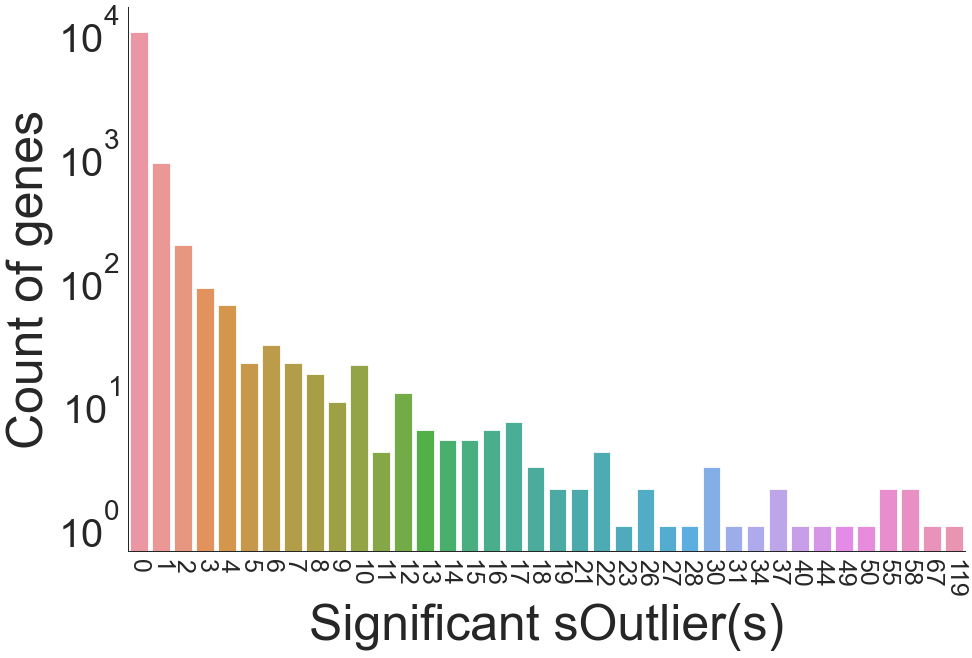

In [9]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (15,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()

bplot = sns.barplot(x = "sig_gene_ind_count", 
                    y = "Gene", 
                    data = soutilers_df.groupby("sig_gene_ind_count").Gene.count().reset_index(),
                    ci = None)

plt.xlabel("Significant sOutlier(s)", fontsize = 50)
plt.ylabel("Count of genes", fontsize = 50)

bplot.set_yscale("log")
ax.tick_params(axis="x", labelsize=25, rotation= -90)
ax.tick_params(axis="y", labelsize = 40) 

plt.savefig('../figures/suppl_figure6_C.svg')

In [10]:
## Combine sOutliers with ConSplice scores

soutilers_df.Gene = soutilers_df.Gene.apply(lambda x: x.strip().split(".")[0])

ConSplice_df.gene_id = ConSplice_df.gene_id.apply(lambda x: x.strip().split(".")[0])

soutilers_df = soutilers_df.rename(columns = {"Gene":"gene_id"})

ConSplice_df_with_outliers_df = pd.merge(ConSplice_df, soutilers_df[["gene_id","sig_gene_ind_count"]], on = "gene_id")

In [11]:
## Get the splicing constarint decile for each variant
ConSplice_df_with_outliers_df["constraint_percentile_bin"] = ConSplice_df_with_outliers_df.apply(get_score_bin, score_column = consplice_col, axis = 1)

In [12]:
## Get per bin proportion of genes

### Each bin will add to 1. That total of that bin will be split between the number of sOutliers per gene.

per_bin_totals = ConSplice_df_with_outliers_df.groupby(["constraint_percentile_bin"])["gene_id"].count().reset_index()

per_bin_totals = per_bin_totals.rename(columns = {"gene_id":"gene_totals"})

for i in range(0,11):

    count_df = ConSplice_df_with_outliers_df.loc[(ConSplice_df_with_outliers_df.sig_gene_ind_count == i)].groupby(["constraint_percentile_bin"])["gene_id"].count().reset_index()
    count_df = count_df.rename(columns = {"gene_id":"{}".format(i)})
    per_bin_totals = pd.merge(per_bin_totals,count_df, on = "constraint_percentile_bin", how = "outer")

## Add the rest
count_df = ConSplice_df_with_outliers_df.loc[(ConSplice_df_with_outliers_df.sig_gene_ind_count > i)].groupby(["constraint_percentile_bin"])["gene_id"].count().reset_index()
count_df = count_df.rename(columns = {"gene_id":">{}".format(i)})
per_bin_totals = pd.merge(per_bin_totals,count_df, on = "constraint_percentile_bin", how = "outer")
    
per_bin_totals = per_bin_totals.fillna(0)

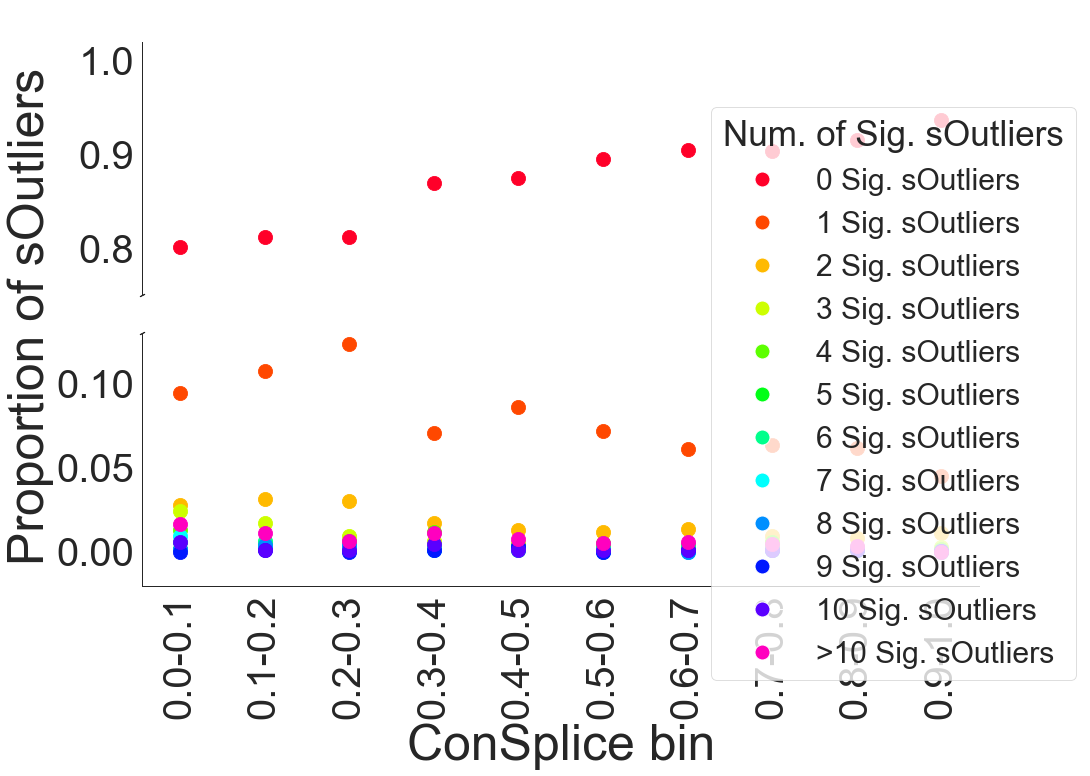

In [13]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (15,10))
fig.subplots_adjust(hspace=0.15)  # adjust space between axes
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()

from matplotlib.lines import Line2D
cm = plt.get_cmap('gist_rainbow')

handle_list = []
for i in range(0,11):
    
    handle_list.append(Line2D([0],[0],
                              marker='o', 
                              color = "white", 
                              markerfacecolor=cm(1.*i/12), 
                              label = "{} Sig. sOutliers".format(i), 
                               markersize = 15))
    axes = ax1 if i == 0 else ax2
    normalized_values = per_bin_totals[str(i)].values / per_bin_totals.gene_totals.values
    axes.scatter(x = per_bin_totals.constraint_percentile_bin.values.tolist(), 
                y = normalized_values,
                s = 200,
                c = cm(1.*i/12),
                label = "{} Sig. sOutliers".format(i))
    
## Add the last one
normalized_values = per_bin_totals[">{}".format(i)].values / per_bin_totals.gene_totals.values
ax2.scatter(x = per_bin_totals.constraint_percentile_bin.values.tolist(), 
            y = normalized_values,
            s = 200, 
            c = cm(1.*12/12),
            label = ">{} Sig. sOutliers".format(i))

handle_list.append(Line2D([0],[0],
                   marker='o', 
                   color = "white", 
                   markerfacecolor=cm(1.*12/12), 
                   label = ">{} Sig. sOutliers".format(i), 
                    markersize = 15))



ax1.set_ylim(0.75,1.02)
ax2.set_ylim(-0.02,0.13)
ax1.tick_params(axis ="y", labelsize = 40)

ax2.tick_params(axis ="y", labelsize = 40)
ax2.tick_params(axis ="x", labelsize = 40, rotation = 90)

   
plt.xlabel("ConSplice bin",fontsize = 50)

fig.text(0.0, 0.5, 'Proportion of sOutliers', va='center', rotation='vertical', fontsize = 50)


# hide the spines between ax and ax2\
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 0], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 1], transform=ax2.transAxes, **kwargs)

fig.legend(handles = handle_list, bbox_to_anchor=(1.01,0.95), fontsize = 30, title = "Num. of Sig. sOutliers", title_fontsize = 35)
ax2.tick_params(axis="x", which = "both", bottom = False, top = False, )

plt.savefig('../figures/suppl_figure6_A.svg')